Characterize traffic patterns from the simulation:
What are the traffic hot spots? Is there any congestion?
What are the travel times? (How) do they vary throughout the day?
What are busy times? How well do they match the commute pattern from NHTS? <-  in data folder 
How do speeds vary spatially and temporally?
What are the most popular roads?
Can you draw conclusions about the simulation setup from the output?


Data to use:
- transims (agents)
- Link volumes
- time series plot matplotlib ?
- plot NHTS in folder

In [5]:
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import json
import numpy as np
from zipfile import ZipFile
import glob
import zipfile
from sklearn.neighbors import BallTree
import numpy as np
from shapely.geometry import LineString

In [61]:
# Link Volumes
os.chdir('/Users/elizabeth/Documents/smc-cuda-intersect/data/emissions_data/Traffic_Volumes/Link_Volumes/') #set folder as wd
link_vols= glob.glob('*.csv')
li = []
link_vols.sort()
for filename in link_vols:
    df = pd.read_csv(filename, index_col=None, header=0)
    df['hour'] = filename[-5]
    df['day'] = filename
    df['day_of_week'] = filename.split('_')[0]
    li.append(df)
link_volumes = pd.concat(li, axis=0, ignore_index=True)

links = gpd.read_file("/Users/elizabeth/Documents/smc-cuda-intersect/data/road_network/RoadNetwork.geojson")
links = links.rename(columns={'LINKID': 'linkID'})
links=links.to_crs(epsg=26916)
links['linkID']=links['linkID'].astype(int)

link_volumes = link_volumes.merge(links,left_on='linkID',right_on='linkID')
os.chdir('/Users/elizabeth/Documents/smc-cuda-intersect/') #restore wd
link_volumes_gpd=gpd.GeoDataFrame(link_volumes, geometry=link_volumes['geometry'])


In [66]:
#commute schedule
home2work=pd.read_csv('data/vehicle_data/Commute Schedule/nhts_home2work.csv')
home2work

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.001368,0.001368,0.001368,0.001368,0.001368,0.000000,0.000000
4,0.020520,0.020520,0.020520,0.020520,0.020520,0.033333,0.033333
5,0.062927,0.062927,0.062927,0.062927,0.062927,0.066667,0.066667
6,0.158687,0.158687,0.158687,0.158687,0.158687,0.133333,0.133333
7,0.238030,0.238030,0.238030,0.238030,0.238030,0.083333,0.083333
8,0.142271,0.142271,0.142271,0.142271,0.142271,0.116667,0.116667
9,0.065663,0.065663,0.065663,0.065663,0.065663,0.033333,0.033333


In [63]:
link_schedule=link_volumes_gpd.groupby(['day_of_week','hour'])['linkVolume'].mean()
days=['Monday','Tuesday','Wednesday','Thursday','Friday']
li=[]
for day in days:
    df=link_schedule[day]
    li.append(df)

In [64]:
df=pd.DataFrame(li)
df.reset_index()
df['day']=days

In [79]:
df2=df.transpose()
df2.columns=days
df3=df2[:-1]

In [97]:
df3.iloc[0:10]

,Monday,Tuesday,Wednesday,Thursday,Friday
hour,,,,,
0,15.7152,15.4451,14.5079,12.1258,15.1727
1,2.56589,2.12124,2.86027,2.67614,1.56569
2,0.00890037,0.00630553,0.0103717,0.0215332,0.0109007
3,0.0361757,0.0100315,0.00201671,0.0275624,0.0338497
4,0.00732127,0.0103181,0.00302506,0.0120586,0.000860585
5,0.0193798,0.0197764,0.000864304,0.00559862,0.000430293
6,0.121878,0.11049,0.105877,0.0753661,0.120912
7,37.1059,34.583,37.4624,32.36,37.8249
8,36.3803,32.3087,40.8695,33.2076,39.5667


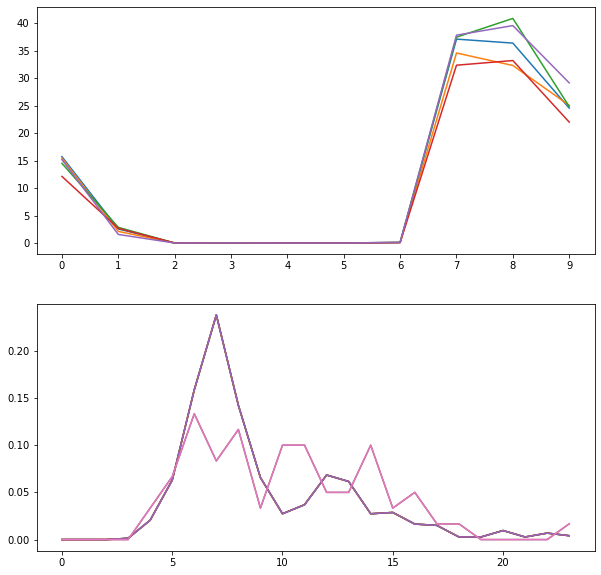

In [98]:
fig,(ax1,ax2)=plt.subplots(2,figsize=(10,10))
ax1.plot(df3.iloc[0:10])
ax2.plot(home2work)

## how to get fractional plot for df3?

In [90]:
df3.loc['Total']= df3.sum()
total=df3.loc['Total']
df4=pd.DataFrame(np.zeros((9,4)))
#for i in np.arange(0,9,1):
#    for j in np.arange(0,4,1):
#        df4.iloc[i,j]=df3.iloc[i,j]/df3.loc['Total']

ValueError: Incompatible indexer with Series